In [63]:
import matplotlib.pyplot as plt
import numpy as np
import miepython
import copy
from scipy.spatial import cKDTree
import pandas as pd
import math

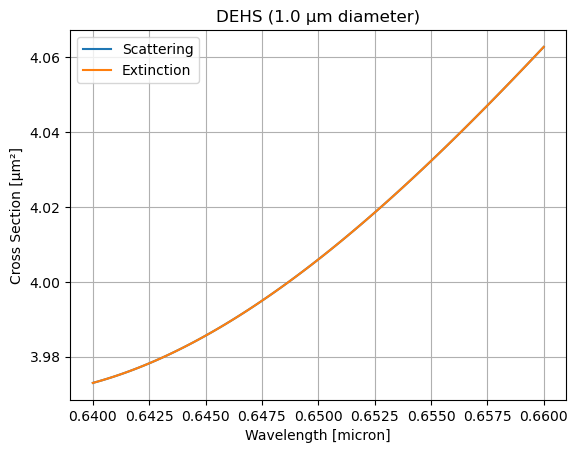

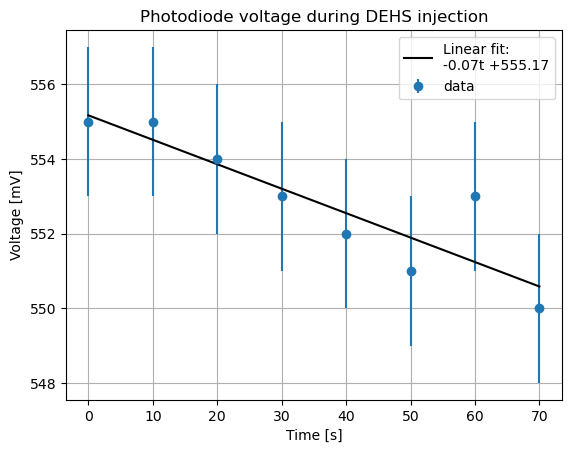

In [54]:
# First goal: estimate number density / optical depth of tank

# Define primary parameters
l = 0.9144 # beam path length [m]
lamb = 650/1e3 # laser wavelength [micron], from https://www.edmundoptics.com/p/red-laser-pointer-db8246c1/10756/
lamb_error = 10/1e3 # +- Uncertainty in wavelength [micron]
n_DEHS = 1.450 # DEHS refractive index at 650nm, from https://www.topas-gmbh.de/dateien/prospekt/dehs_prspe.pdf
rho_DEHS = 912 # DEHS density, kg/m^3
a = 0.5 # particle radius [micron]
tank_vol = 0.9144*2 * 1.2192 # Tank volume [m^3]
pd_data = np.array([[0.,555.], # timeseries [s] of photodiode voltage [mV]
                      [10.,555.],
                      [20.,554.],
                      [30.,553.],
                      [40.,552.],
                      [50.,551.],
                      [60.,553.],
                      [70.,550.]])
pd_error = 2 # Uncertainty in voltmeter reading [mV]
pd_min = 401 # Voltmeter reading when no laser incident [mV]
pd_max = 555 # Voltmeter reading when laser is incident [mV]

# Compute secondary parameters
lamb_ls = np.linspace(lamb-lamb_error, lamb+lamb_error, 100)
n_DEHS_ls = np.zeros_like(lamb_ls)+n_DEHS
x = 2 * np.pi * a / lamb_ls
m,c = np.polyfit(pd_data[:,0],pd_data[:,1],1) # (mV/s, mV) 

# Compute extinction coeffs. 
qext, qsca, qback, g = miepython.mie(n_DEHS_ls, x)

# Plot
plt.plot(lamb_ls, qsca, label = "Scattering")
plt.plot(lamb_ls, qext, label = "Extinction")
plt.title(str("DEHS ("+str(2*a)+" µm diameter)"))
plt.xlabel("Wavelength [micron]")
plt.ylabel("Cross Section [µm²]")
plt.legend()
plt.grid()
plt.show()

plt.errorbar(pd_data[:,0],pd_data[:,1], yerr=pd_error, fmt="o",label = "data")
plt.plot(pd_data[:,0],(m*pd_data[:,0] + c),c="black", label = str("Linear fit:\n"+str(round(m,2))+"t +"+str(round(c,2))))
plt.title("Photodiode voltage during DEHS injection")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.legend()
plt.grid()
plt.show()

In [58]:
# We are solving for the mass flow rate, Q. This is how many kg/sec of DEHS is flowing into the tank at 20psi.
# Assumptions:
# Assume all scattered light is lost.
# Assume completely homogenous distribution of 1 micron droplets.
# Assume linear response of photodiode to flux
# Assume beam is exaclty 650nm

def compute_DEHS_num(v):
    # Takes a pd voltmeter reading as input [mV], computes the number of DEHS droplets needed to account for that absorption [#/m^3]
    # Compute optical depth, tau
    tau = np.log((pd_max - pd_min)/(v - pd_min))
    # Compute scattering cross section (in micron^2)
    qext, qsca, qback, g = miepython.mie(n_DEHS, 2*np.pi*a/lamb)
    # Compute number density
    n = tau / (qext*(1e-6)**2*l)
    return n


def compute_mass_flow(data,plot=False):
    # Takes a (n,2) time series of pd voltage measurements and returns best fit mass flow rate [kg/s]
    # Compute number density at each time
    n = compute_DEHS_num(data[:,1])
    if plot:
        plt.plot(data[:,0],n)
        plt.title("DEHS number density")
        plt.xlabel("Time [s]")
        plt.ylabel("Density [1/m$^3$]")
        plt.grid()
        plt.show()
    # Convert to mass density
    rho = 4/3*np.pi*(a*1e-6)**3 * rho_DEHS * n
    # Convert to total mass in the tank
    mass = rho * tank_vol
    # Return gradient of linear fit
    return np.polyfit(data[:,0],mass,1)[0]

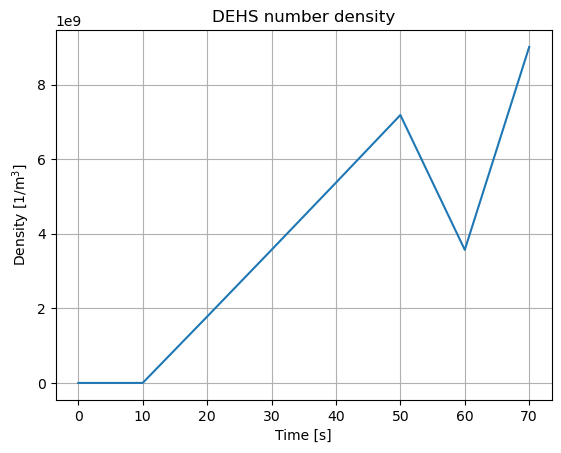

Mass flow: 0.00012540450915075917 g/s
Uncertainty: 1.6748721079240733e-06 g/s


In [59]:
mass_flow = compute_mass_flow(pd_data,plot=True)
error_data = pd_data.copy()
error_data[:,1] = error_data[:,1] - pd_error
mass_flow_error = compute_mass_flow(error_data) - mass_flow
print("Mass flow:",mass_flow*1e3,"g/s")
print("Uncertainty:",mass_flow_error*1e3,"g/s")

In [91]:
# From cordy: code to read and plot lidar
def d2d(hyp, percent):
    theta = (3/4)*math.pi*percent
    x = math.cos(theta)*hyp
    y = math.sin(theta)*hyp
    return [percent, hyp]
# d2d

def read_and_save(file_path, start_line, output_file):
    with open(file_path, 'r') as file:
        # Skip lines until reaching the start_line
        for _ in range(start_line - 1):
            next(file)
        
        # Read the rest of the file and save to output_file
        with open(output_file, 'w') as output:
            for line in file:
                output.write(line)
# read_and_save

def plot_scatter(array_data):
    # Extract x and y values from array data
    x_values = [point[0] for point in array_data]
    y_values = [point[1] for point in array_data]

    # Create scatter plot
    plt.scatter(x_values, y_values)
    plt.xlabel('Percent Through Scan')
    plt.ylabel('Millimeters')
    plt.title('LiDAR Data Scatterplot')
    plt.grid(True)
    plt.show()
# plot_scatter

# uses log file to plot data on mesh grid
def data_xy(file, startPer, endPer):

    read_and_save(file, 36, 'output.txt')

    with open('output.txt', 'r') as file:
        data_str = file.read().strip()  # Read the content and remove leading/trailing whitespaces

# Remove the brackets and split the string at semicolons
    numbers = data_str[1:-1].split(';')

# Convert each element to an integer
    numbers = [int(item) for item in numbers]

# make start and end indices for %
    whole = len(numbers)
    startDex = whole * startPer
    endDex = whole * endPer
    newArray = [numbers[math.floor(startDex)]]

# create new array with only points between % spec
    for i in range(len(numbers)):
        if (i > startDex) and (i < endDex):
            newArray = np.append(newArray, numbers[i])
# set old array = reduced array
    numbers = newArray

    # converts the numbers in the initial array into usable data
    twoDim = np.array([[0, 0]])  # Initialize an empty 2D array
# define twoDim as zeros of entire array, then change values instead of append
    
    for i in range(len(numbers)):
        # Create a 2D array for each number and append it to twoDim
        row = d2d(numbers[i], i / len(numbers) - 1)
        twoDim = np.append(twoDim, [row], axis=0)  # Append row along the rows axis

    return twoDim[1:, :]

def knn_heights(points, heights, k, min_height_difference):
    tree = cKDTree(points)
    indices = []
    
    for i, point in enumerate(points):
        # Query k nearest neighbors
        distances, neighbor_indices = tree.query(point, k=k+1)
        
        # Exclude the point itself from neighbors
        distances = distances[1:]
        neighbor_indices = neighbor_indices[1:]
        
        # Check height difference with neighbors
        for neighbor_index, distance in zip(neighbor_indices, distances):
            height_diff = abs(heights[i] - heights[neighbor_index])
            if height_diff >= min_height_difference:
                indices.append(i)
                break
    
    return indices

(201, 2)

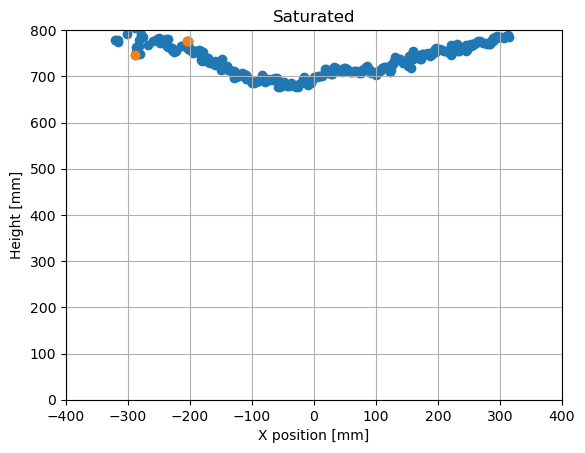

In [132]:
dtheta = 0.25/180*np.pi # step size, radians
tank_height = 1.2192 * 1e3 # tank height in mm

rtheta = data_xy('scans/april25_saturated.ubh', 0.1, 0.9)
indices = knn_heights(rtheta, rtheta[:, 1], 35, 15)
n = len(rtheta)
rtheta[:,0] = np.linspace(-n/2*dtheta,n/2*dtheta,n) # recast index 0 as angle
xz = np.zeros_like(rtheta) # array for xz coords
xz[:,0] = rtheta[:,1]*np.sin(rtheta[:,0])
xz[:,1] = tank_height - rtheta[:,1]*np.cos(rtheta[:,0])

xlims=(-400,400)
ylims=(0,800)
plt.scatter(xz[:,0], xz[:,1])
plt.scatter(xz[indices,0], xz[indices,1])
plt.xlabel("X position [mm]")
plt.ylabel("Height [mm]")
plt.grid()
plt.title("Saturated")
plt.xlim(xlims)
plt.ylim(ylims)
plt.savefig("Saturated.png")
dataArray.shape

In [94]:
indices

[0, 1, 2, 3, 4, 5, 6, 10, 73, 74, 75, 146, 147, 148]

In [95]:
xz[indices,0]

array([-543.48097444, -542.60006826, -536.62950744, -527.36339384,
       -521.43621936, -514.70574128, -505.19304409, -484.46587569,
       -124.85531617, -103.07270384,  -92.23181419,  168.09469986,
        193.59467939,  231.08309479])